In [1]:
import pandas as pd
import scipy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math as m
import sklearn
import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

In [2]:
# Соединим тренировочную и тестовыю выборки в одну для модификации данных.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_size = train.shape[0] # запоминаем индекс с которого начинается test
all_data = pd.concat([train, test])
all_data = all_data.reset_index(drop=True)

In [3]:
all_data.describe()

id  Количество.комнат       Студия  Общая.площадь  \
count  1585.000000        1585.000000  1585.000000    1585.000000   
mean    816.509779           2.021451     0.056782      49.911596   
std     471.187790           1.005437     0.231499      20.154915   
min       0.000000           1.000000     0.000000      10.000000   
25%     407.000000           1.000000     0.000000      36.000000   
50%     817.000000           2.000000     0.000000      46.200000   
75%    1232.000000           3.000000     0.000000      62.000000   
max    1616.000000           5.000000     1.000000     144.000000   

              Этаж  Этажей.в.доме     Парковка  Без.ремонта  Дизайнерский  \
count  1585.000000    1585.000000  1585.000000  1585.000000   1585.000000   
mean      4.875710       8.740063     0.136909     0.106625      0.035962   
std       3.794643       4.842005     0.343859     0.308733      0.186255   
min       1.000000       2.000000     0.000000     0.000000      0.000000   
25%       2.000000       5.000000     0.000000     0.000000      0.000000   
50%       4.000000       9.000000     0.000000     0.000000      0.000000   
75%       6.000000      10.000000     0.000000     0.000000      0.000000   
max      25.000000      27.000000     1.000000     1.000000      1.000000   

        Евроремонт  ...  Одежда..1000  Супер3кет.1000  Кинотеатр.1000  \
count  1585.000000  ...   1585.000000     1585.000000     1585.000000   
mean      0.088328  ...     11.321767        4.845426        0.162145   
std       0.283861  ...     16.099162        3.191601        0.406178   
min       0.000000  ...      0.000000        0.000000        0.000000   
25%       0.000000  ...      2.000000        2.000000        0.000000   
50%       0.000000  ...      5.000000        5.000000        0.000000   
75%       0.000000  ...     13.000000        7.000000        0.000000   
max       1.000000  ...     86.000000       14.000000        2.000000   

         Кафе.1000     АЗС.1000  Детский.сад.1000     Бар.1000    Банк.1000  \
count  1585.000000  1585.000000       1585.000000  1585.000000  1585.000000   
mean      8.523028     2.418297         13.588013     4.489590     7.394953   
std      10.063291     1.665088          7.586037     6.686433     7.481997   
min       0.000000     0.000000          0.000000     0.000000     0.000000   
25%       3.000000     1.000000          8.000000     1.000000     2.000000   
50%       6.000000     2.000000         13.000000     3.000000     5.000000   
75%      10.000000     3.000000         18.000000     5.000000    11.000000   
max      72.000000     8.000000         42.000000    55.000000    44.000000   

       Аптека.1000          Цена  
count  1585.000000  8.020000e+02  
mean     14.087697  2.653089e+06  
std       8.289841  1.085698e+06  
min       0.000000  4.990000e+05  
25%       8.000000  1.950000e+06  
50%      13.000000  2.500000e+06  
75%      19.000000  3.250000e+06  
max      40.000000  6.800000e+06  

[8 rows x 48 columns]

In [4]:
all_data = all_data.drop(columns='id')

### Исследум данные на коллинеарность. Для этого построим и визуализируем матрицу корреляции в виде тепловой карты 

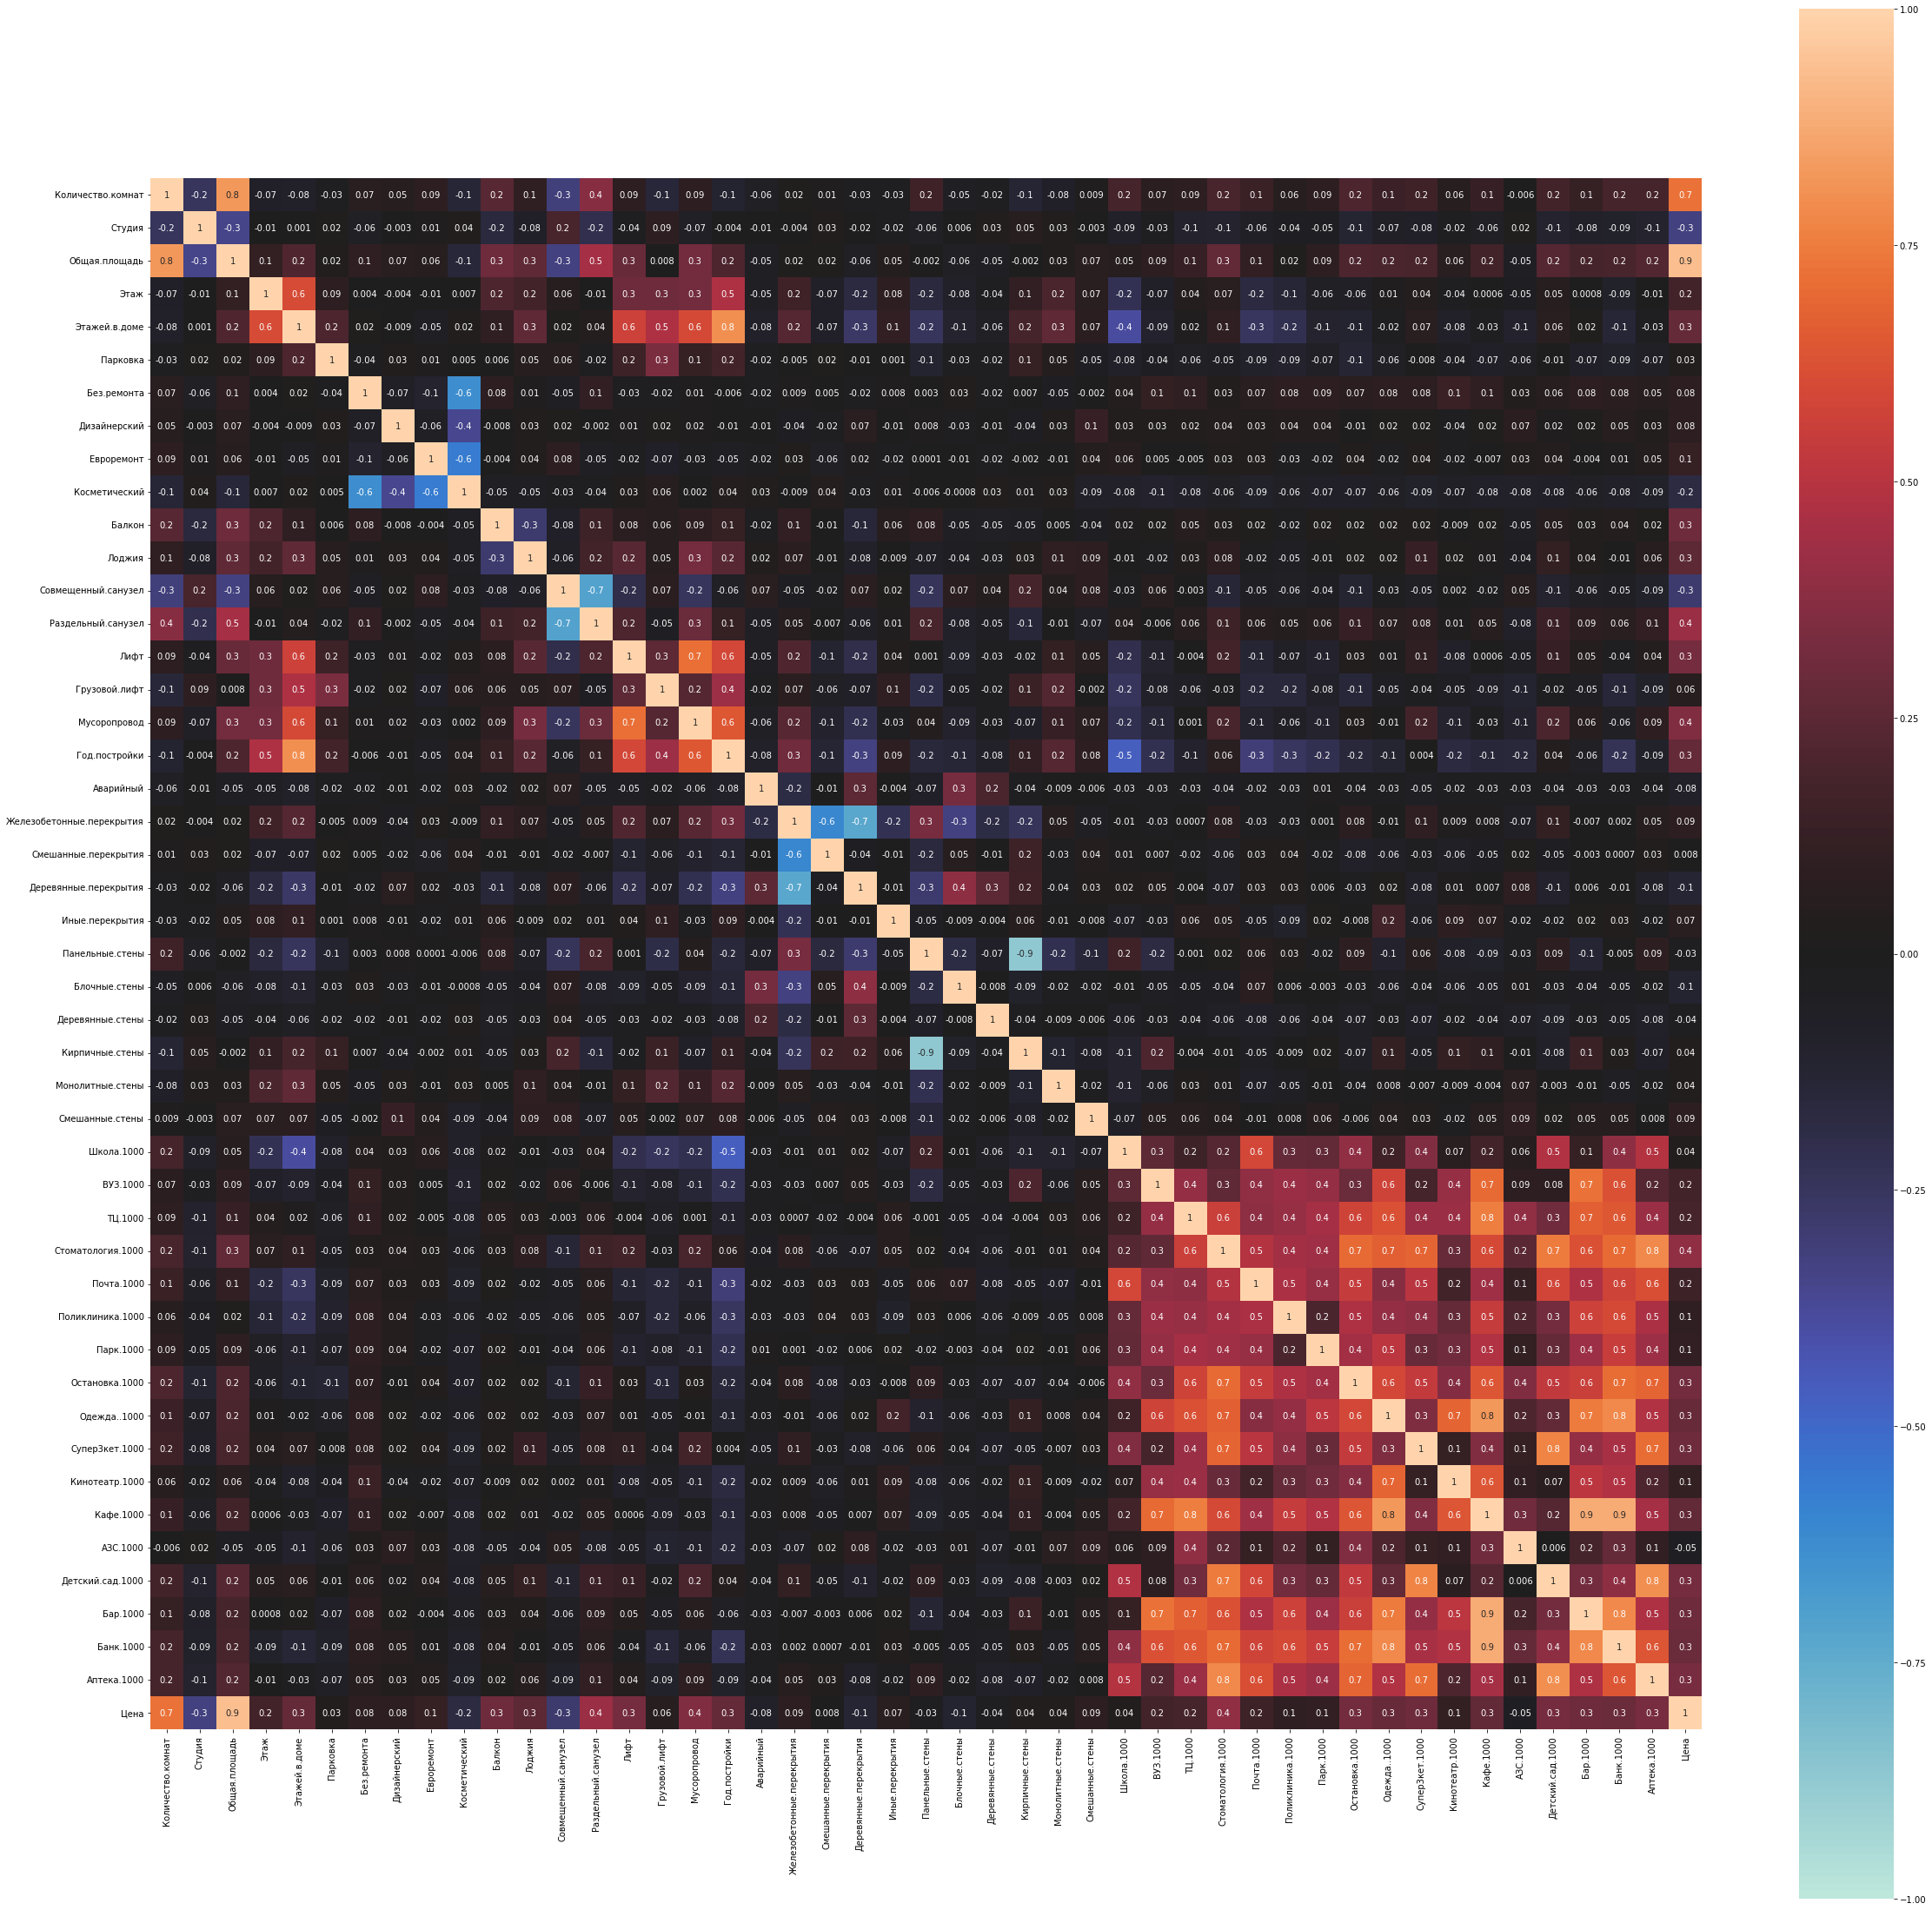

In [6]:
cols = all_data.columns
plt.figure(figsize=(40, 40))
hm = sns.heatmap(all_data[cols].corr(), cbar=True, annot=True, vmin=-1, vmax=1, center= 0, square=True, fmt='.1g')

#### Удалим признаки, которые плохо коррелируют с ценой или сильно коррелируют между собой

In [7]:
col_del = ['Количество.комнат', 'Парковка',  'Блочные.стены', 'Грузовой.лифт', 'Аварийный', 'Деревянные.стены', 
           'Железобетонные.перекрытия', 'Смешанные.перекрытия', 'Иные.перекрытия', 'Панельные.стены', 'Деревянные.перекрытия', 
           'Кирпичные.стены', 'Монолитные.стены', 'Смешанные.стены', 
           'Кинотеатр.1000', 'Парк.1000', 'Без.ремонта', 'Евроремонт', 'Дизайнерский', 
           'Школа.1000', 'АЗС.1000', 'Поликлиника.1000'
           ,  'Кафе.1000', 'Почта.1000',
           'Этаж',  'Совмещенный.санузел', 'Банк.1000', 'Аптека.1000', 'Этажей.в.доме', 'Супер3кет.1000']
#           'ВУЗ.1000', 'ТЦ.1000', 'Косметический','Остановка.1000','Стоматология.1000',

In [9]:
def delete(df: pd.DataFrame, list_cols: list) -> pd.DataFrame:
    """ Функция для удаления столбцов из dataframe
    
    :param df       : исходный dataframe
    :param list_cols: список с названиями столбов для удаления
    
    :return df      : dataframe c удаленными столбцами
    """
    df = df.copy()
    for i in list_cols:
        df = df.drop(columns=i)
    return df

In [10]:
all_data = delete(all_data, col_del) 

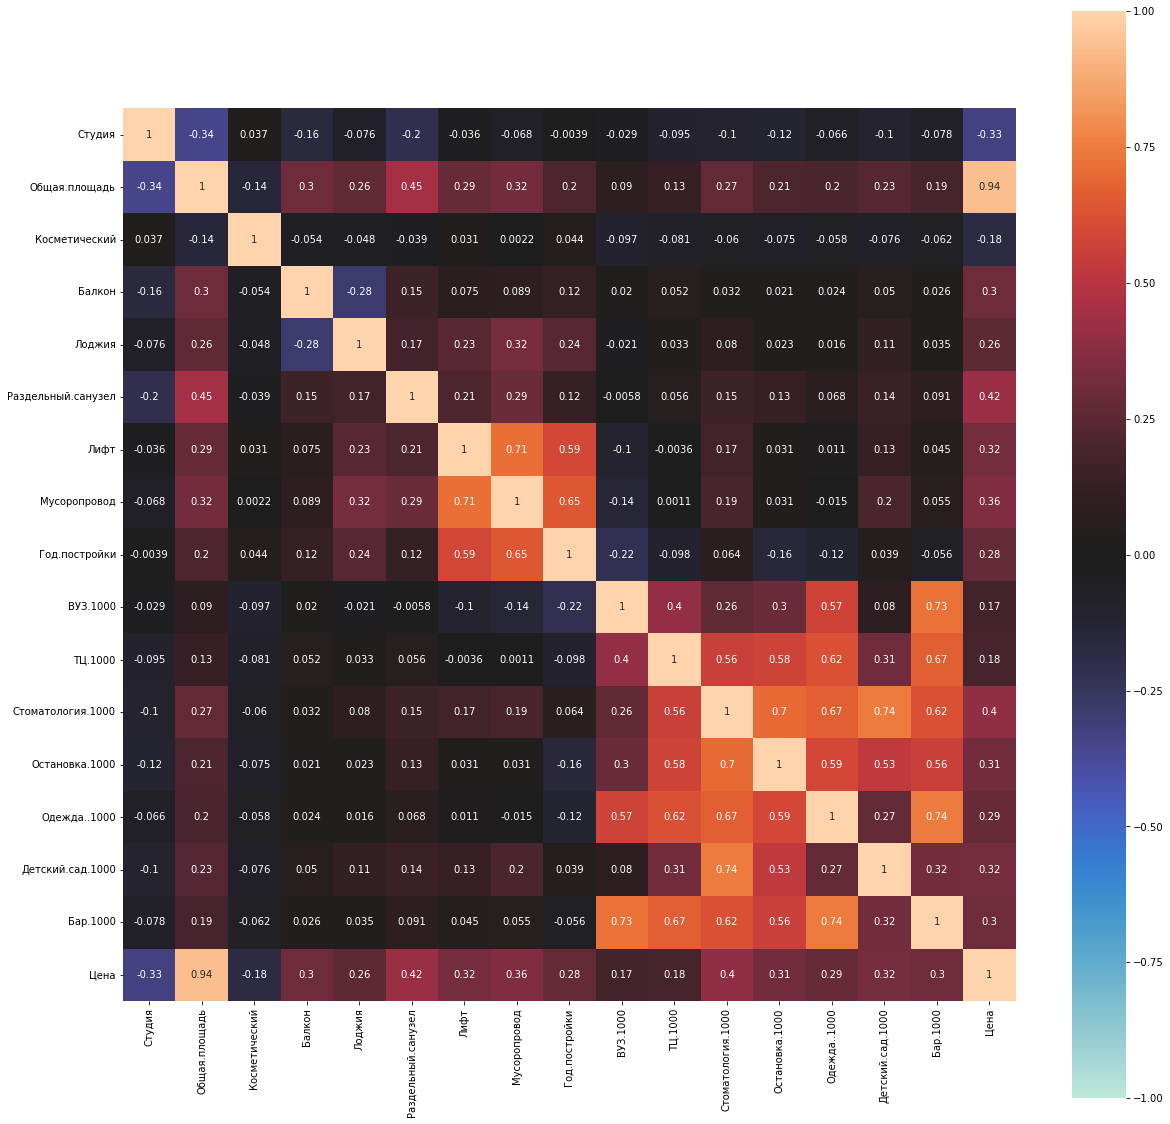

In [11]:
cols = all_data.columns
cols
plt.figure(figsize=(20, 20))
hm = sns.heatmap(all_data[cols].corr(), cbar=True, annot=True, vmin=-1, vmax=1, center= 0, square=True, fmt='.2g')

In [12]:
all_data.describe()

Студия  Общая.площадь  Косметический       Балкон       Лоджия  \
count  1585.000000    1585.000000    1585.000000  1585.000000  1585.000000   
mean      0.056782      49.911596       0.769085     0.585489     0.204416   
std       0.231499      20.154915       0.421551     0.601275     0.445069   
min       0.000000      10.000000       0.000000     0.000000     0.000000   
25%       0.000000      36.000000       1.000000     0.000000     0.000000   
50%       0.000000      46.200000       1.000000     1.000000     0.000000   
75%       0.000000      62.000000       1.000000     1.000000     0.000000   
max       1.000000     144.000000       1.000000     4.000000     3.000000   

       Раздельный.санузел         Лифт  Мусоропровод  Год.постройки  \
count         1585.000000  1585.000000   1585.000000    1585.000000   
mean             0.461199     0.530599      0.504732    1985.641009   
std              0.512387     0.581038      0.500135      20.236118   
min              0.000000     0.000000      0.000000    1935.000000   
25%              0.000000     0.000000      0.000000    1969.000000   
50%              0.000000     1.000000      1.000000    1982.000000   
75%              1.000000     1.000000      1.000000    2007.000000   
max              2.000000     4.000000      1.000000    2018.000000   

          ВУЗ.1000      ТЦ.1000  Стоматология.1000  Остановка.1000  \
count  1585.000000  1585.000000        1585.000000     1585.000000   
mean      3.213249     1.921767           8.767192        9.774763   
std       6.125370     1.884328           7.086011        5.521114   
min       0.000000     0.000000           0.000000        0.000000   
25%       0.000000     0.000000           3.000000        6.000000   
50%       1.000000     2.000000           7.000000        9.000000   
75%       4.000000     3.000000          12.000000       13.000000   
max      43.000000    11.000000          35.000000       31.000000   

       Одежда..1000  Детский.сад.1000     Бар.1000          Цена  
count   1585.000000       1585.000000  1585.000000  8.020000e+02  
mean      11.321767         13.588013     4.489590  2.653089e+06  
std       16.099162          7.586037     6.686433  1.085698e+06  
min        0.000000          0.000000     0.000000  4.990000e+05  
25%        2.000000          8.000000     1.000000  1.950000e+06  
50%        5.000000         13.000000     3.000000  2.500000e+06  
75%       13.000000         18.000000     5.000000  3.250000e+06  
max       86.000000         42.000000    55.000000  6.800000e+06

In [13]:
def hystogramma(col: pd.Series, name: str) -> None:
    """ Функция для построения гистограммы
    
    :param col  : колонка из dataframe
    :param name : название столбца
    """
    fig, ax = plt.subplots()
    sns.histplot(v, kde=True, ax=ax, bins=15)
    plt.xlabel(name, size=15)
    plt.ylabel("frequency", size=15)
    plt.show()

In [16]:
# Разъединим выборку обратно на тренировочную и тестовую
train_changed = all_data.iloc[:train_size,:]
test_changed = all_data.iloc[train_size:,:]
test_changed = test_changed.reset_index(drop=True)

In [17]:
train_new = train_changed[cols]
train_new = train_new.drop(columns= 'Цена')
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Студия              802 non-null    int64  
 1   Общая.площадь       802 non-null    float64
 2   Косметический       802 non-null    int64  
 3   Балкон              802 non-null    int64  
 4   Лоджия              802 non-null    int64  
 5   Раздельный.санузел  802 non-null    int64  
 6   Лифт                802 non-null    int64  
 7   Мусоропровод        802 non-null    int64  
 8   Год.постройки       802 non-null    int64  
 9   ВУЗ.1000            802 non-null    int64  
 10  ТЦ.1000             802 non-null    int64  
 11  Стоматология.1000   802 non-null    int64  
 12  Остановка.1000      802 non-null    int64  
 13  Одежда..1000        802 non-null    int64  
 14  Детский.сад.1000    802 non-null    int64  
 15  Бар.1000            802 non-null    int64  
dtypes: float

In [18]:
x = train_new
y = train_changed['Цена'] 

### Разделим на train и valid

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.75, random_state = 2037)

In [20]:
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing
sc_x = StandardScaler()
sc_y = StandardScaler()
x_std = sc_x.fit_transform(x)
y_std = sklearn.preprocessing.scale(y)

In [21]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    x_std, y_std, test_size=0.65, random_state=2037)

#### Реализуем механизм прямого отбора признаков 

In [22]:
def direct_selection(model, x: pd.Series, y: pd.Series, x_2: pd.Series, y_2: pd.Series) -> list:
    """ Функция реализующая механизм прямого отбора признаков """
    checked = []
    marks = []
    for i in range(len(x.columns)):
        checked.append(x.columns[i])
        cols = x[checked]
        model = model.fit(cols, y)
        y_2_predicted = model.predict(x_2[checked])
        rmse = mse(y_2, y_2_predicted, squared = False)
        if (len(marks) != 0):
            if (marks[-1] <= rmse):
                print(checked.pop(-1))
            else:
                marks.append(rmse)
        else:
            marks.append(rmse)
    print(marks)
    return marks[-1]

In [23]:
def marks(y_test_predicted: pd.Series) -> None:
    """ Функция вывода метрик RMSE, R2, Adj.R2"""
    rms = mse(y_test, y_test_predicted, squared = False)
    r2 = r2_score(y_test, y_test_predicted)
    adj = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    print("Коэффиценты: ")
    print("RMSE = %f"%rms)
    print("R2 = %f"%r2)
    print("Adj.R2 = %f"%adj)

In [24]:
def marks_2(x: pd.Series, y: pd.Series, y_test_predicted: pd.Series) -> None:
    rms = mse(y, y_test_predicted, squared = False)
    r2 = r2_score(y, y_test_predicted)
    adj = 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)
    print("Коэффиценты: ")
    print("RMSE = %f"%rms)
    print("R2 = %f"%r2)
    print("Adj.R2 = %f"%adj)

## Обучение моделей

### 1. Линейная регрессия (МНК)

In [25]:
x_ = sm.add_constant(x_train)
smm = sm.OLS(y_train, x_)
model = smm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     448.1
Date:                Tue, 26 Apr 2022   Prob (F-statistic):          2.58e-315
Time:                        15:11:41   Log-Likelihood:                -8436.7
No. Observations:                 601   AIC:                         1.691e+04
Df Residuals:                     584   BIC:                         1.698e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.552e+07   1.82

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
x_2 = sm.add_constant(x_test)
marks(model.predict(x_2))

Коэффиценты: 
RMSE = 312068.084001
R2 = 0.909069
Adj.R2 = 0.901162


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
skm = lm.LinearRegression()
# direct_selection(skm, x_train, y_train, x_test, y_test)

In [28]:
skm.fit(x_train, y_train)
marks(skm.predict(x_test))

Коэффиценты: 
RMSE = 312068.084001
R2 = 0.909069
Adj.R2 = 0.901162


### 2. Регрессия Лассо 

In [30]:
las = lm.Lasso()
las.fit(x_train, y_train)
marks(las.predict(x_test))

Коэффиценты: 
RMSE = 312068.229131
R2 = 0.909069
Adj.R2 = 0.901162


### 3. Гребневая регрессия 

In [31]:
rig = lm.Ridge(alpha=0.01)
rig.fit(x_train, y_train)
marks(rig.predict(x_test))

Коэффиценты: 
RMSE = 312068.102208
R2 = 0.909069
Adj.R2 = 0.901162


### 4. Elastic-Net 

In [32]:
en = lm.ElasticNet(alpha=0.15, l1_ratio=0.7)
en.fit(x_train, y_train)
marks(en.predict(x_test)) 

Коэффиценты: 
RMSE = 312333.788254
R2 = 0.908915
Adj.R2 = 0.900994


### 5. Метод наименьших углов (Least-angle regression)

In [34]:
lar = lm.Lars()
# direct_selection(lar, x_train, y_train, x_test, y_test)
lar.fit(x_train, y_train)
marks(lar.predict(x_test))

Коэффиценты: 
RMSE = 340971.965253
R2 = 0.891445
Adj.R2 = 0.882006


### 6. Байесовская регрессия

In [35]:
bar = lm.BayesianRidge(alpha_1=450, alpha_2=0.3, lambda_1=1e-07, lambda_2=450)
bar.fit(x_train, y_train)
marks(bar.predict(x_test))

Коэффиценты: 
RMSE = 312404.386045
R2 = 0.908873
Adj.R2 = 0.900949


### 7. Обобщенная линейная регрессия (обобщенный МНК)

In [36]:
gls = sm.GLS(y_train, x_train)
results = gls.fit()
print(results.summary())

                                 GLS Regression Results                                
Dep. Variable:                   Цена   R-squared (uncentered):                   0.987
Model:                            GLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              2887.
Date:                Tue, 26 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:16:24   Log-Likelihood:                         -8471.8
No. Observations:                 601   AIC:                                  1.698e+04
Df Residuals:                     585   BIC:                                  1.705e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [37]:
marks(results.predict(x_test))

Коэффиценты: 
RMSE = 319085.863187
R2 = 0.904934
Adj.R2 = 0.896667


### 8. Взвешенный МНК 

In [38]:
wls = sm.WLS(y, x)
results = wls.fit()
print(results.summary())

                                 WLS Regression Results                                
Dep. Variable:                   Цена   R-squared (uncentered):                   0.988
Model:                            WLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              3920.
Date:                Tue, 26 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:16:53   Log-Likelihood:                         -11301.
No. Observations:                 802   AIC:                                  2.263e+04
Df Residuals:                     786   BIC:                                  2.271e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [39]:
marks(results.predict(x_test))

Коэффиценты: 
RMSE = 311334.691851
R2 = 0.909496
Adj.R2 = 0.901626


### 9. Полиномиальная регрессия

In [41]:
from sklearn.preprocessing import PolynomialFeatures
model = PolynomialFeatures(degree = 1)
x_poly = model.fit_transform(x_train)
model.fit(x_train, y_train)
reg_line = lm.LinearRegression()
reg_line.fit(x_poly, y_train)
marks(reg_line.predict(model.fit_transform(x_test)))

Коэффиценты: 
RMSE = 312068.084001
R2 = 0.909069
Adj.R2 = 0.901162


### 10 XGB Regressor

In [42]:
from xgboost import XGBRegressor
xgb = XGBRegressor( seed = 2,
                      n_estimators=500, 
                      max_depth=6, 
                      min_child_weight=2, 
                      colsample_bytree=0.7, 
                      gamma=1, 
                      scale_pos_weight=0.6, 
                      reg_alpha=0.1, 
                      reg_lambda=1,
                      learning_rate=0.2,
                      use_label_encoder=False,
                      predictor="gpu_predictor")
xgb.fit(x_train, y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1,
             predictor='gpu_predictor', random_state=2, reg_alpha=0.1,
             reg_lambda=1, scale_pos_weight=0.6, seed=2, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [43]:
marks(xgb.predict(x_test)) 

Коэффиценты: 
RMSE = 291739.465259
R2 = 0.920530
Adj.R2 = 0.913620


### 11 Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
frst = RandomForestRegressor(
                            random_state=42,
                            n_estimators=350,
                            criterion='mse',
                            oob_score=True,
                            min_samples_split=3, 
                            min_samples_leaf=1,
                            max_depth=10, #кол-во слоев в дереве
                            n_jobs=-1)
frst.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=350,
                      n_jobs=-1, oob_score=True, random_state=42)

In [45]:
marks(frst.predict(x_test))

Коэффиценты: 
RMSE = 292961.978659
R2 = 0.919863
Adj.R2 = 0.912894


In [46]:
def create_submission(id_col: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    """ Функция для сохранения полученных значений"""
    submission = pd.DataFrame({
        'id': id_col,
        'Цена': y_pred
    })
    return submission